# 4章 差分の差分法（DID）とCausalImpact

In [1]:
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append('../scripts/')

import numpy as np
import pandas as pd

import rdata
from rdd import rdd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from causalimpact import CausalImpact
from statsmodels.stats.weightstats import ttest_ind
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

from propensity_score_matching import PropensityScoreMatching

## 4.1 DID（差分の差分法）

### 4.1.3 DIDのアイデアを用いた集計分析

In [2]:
# nekoumeiさんの処理から拝借（https://github.com/nekoumei/cibook-python/blob/master/notebook/ch4_did.ipynb）

## 1849年におけるエリア毎のコレラによる死者数
### Southwark and Vauxhall Company
sv1849 = [283,157,192,249,259,226,352,97,111,8,235,92]
### Lambeth Company & Southwark and Vauxhall Company
lsv1849 = [256,267,312,257,318,446,143,193,243,215,544,187,153,81,113,176]

## 1849年におけるエリア毎のコレラによる死者数
### Southwark and Vauxhall Company
sv1854 = [371, 161, 148, 362, 244, 237, 282, 59, 171, 9, 240, 174]
### Lambeth Company & Southwark and Vauxhall Company
lsv1854 = [113,174,270,93,210,388,92,58,117,49,193,303,142,48,165,132]

## コレラの死者数を会社ごとにまとめる
sv_death = sv1849 + sv1854
lsv_death = lsv1849 + lsv1854

## どのデータがどのエリアのものか
sv_area = [f'sv_{i}' for i in range(1, len(sv1849)+1)] + [f'sv_{i}' for i in range(1, len(sv1854)+1)]
lsv_area = [f'lsv_{i}' for i in range(1, len(lsv1849)+1)] + [f'lsv_{i}' for i in range(1, len(lsv1854)+1)]

## どのデータがどの年のものか
sv_year = [1849 for i in range(0, len(sv1849))] + [1854 for i in range(0, len(sv1854))]
lsv_year = [1849 for i in range(0, len(lsv1849))] + [1854 for i in range(0, len(lsv1854))]

## Southwark & Vauxhallのデータフレームを作成
sv = pd.DataFrame({
    'area': sv_area,
    'year': sv_year,
    'death': sv_death,
    'LSV': 0,
    'company': 'Southwark and Vauxhall'
})

## Lambeth & Southwark and Vauxhallのデータフレームを作成
lsv = pd.DataFrame({
    'area': lsv_area,
    'year': lsv_year,
    'death': lsv_death,
    'LSV': 1,
    'company': 'Lambeth & Southwark and Vauxhall'
})

## 地域・年別のデータセットの作成
JS_df = pd.concat([sv, lsv], ignore_index=True)

## 会社別のデータセットを作成
JS_sum = JS_df.groupby(['company', 'LSV', 'year'], as_index=False).death.sum()

In [3]:
JS_grp_summary = JS_sum.pivot_table(values=['death'], columns=['year'], index=['company'])
JS_grp_summary.columns = ['death_1849', 'death_1854']

In [4]:
JS_grp_summary['gap'] = JS_grp_summary['death_1854'] - JS_grp_summary['death_1849']
JS_grp_summary['gap_rate'] = JS_grp_summary['death_1854']/JS_grp_summary['death_1849'] - 1

In [5]:
JS_grp_summary

,death_1849,death_1854,gap,gap_rate
company,,,,
Lambeth & Southwark and Vauxhall,3904,2547,-1357,-0.347592
Southwark and Vauxhall,2261,2458,197,0.087130


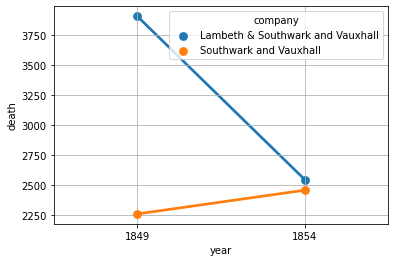

In [6]:
sns.pointplot(data=JS_sum, x='year', y='death', hue='company')
plt.grid()

### 4.1.4 回帰分析を利用したDID

In [7]:
JS_sum

,company,LSV,year,death
0,Lambeth & Southwark and Vauxhall,1,1849,3904
1,Lambeth & Southwark and Vauxhall,1,1854,2547
2,Southwark and Vauxhall,0,1849,2261
3,Southwark and Vauxhall,0,1854,2458


In [8]:
JS_sum['D1854'] = JS_sum['year'].map(lambda x: 1 if x == 1854 else 0)
JS_sum['D1854_LSV'] = JS_sum['D1854'] * JS_sum['LSV']

In [9]:
JS_did = smf.ols(
    formula='death ~ LSV + D1854 + D1854_LSV',
    data=JS_sum
).fit()

JS_did.summary().tables[1]

/Users/shinya-yaginuma/.local/share/virtualenvs/cibook-study-D1CYHMng/lib/python3.7/site-packages/statsmodels/stats/stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  "samples were given." % int(n), ValueWarning)


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2261.0000,inf,0,nan,nan,nan
LSV,1643.0000,inf,0,nan,nan,nan
D1854,197.0000,inf,0,nan,nan,nan
D1854_LSV,-1554.0000,inf,-0,nan,nan,nan


In [10]:
JS_df['D1854'] = JS_df['year'].map(lambda x: 1 if x == 1854 else 0)
JS_df['D1854_LSV'] = JS_df['D1854'] * JS_df['LSV']

In [11]:
JS_did_area = smf.ols(
    formula='death ~ LSV + D1854 + D1854_LSV + area',
    data=JS_df
).fit()

JS_did_area_result = pd.DataFrame(
    JS_did_area.summary().tables[1].data[1:], 
    columns=JS_did_area.summary().tables[1].data[0]
)

JS_did_area_result = JS_did_area_result.set_index('')

JS_did_area_result.loc[['Intercept', 'LSV', 'D1854', 'D1854_LSV']]

,coef,std err,t,P>|t|,[0.025,0.975]
,,,,,,
Intercept,177.7076,15.710,11.312,0.000,145.415,210.000
LSV,49.1987,44.773,1.099,0.282,-42.833,141.230
D1854,16.4167,25.365,0.647,0.523,-35.721,68.555
D1854_LSV,-101.2292,33.554,-3.017,0.006,-170.201,-32.257


In [12]:
JS_df['log_death'] = np.log(JS_df['death'])

JS_did_area_log = smf.ols(
    formula='log_death ~ LSV + D1854 + D1854_LSV + area',
    data=JS_df
).fit()

JS_did_area_log_result = pd.DataFrame(
    JS_did_area_log.summary().tables[1].data[1:], 
    columns=JS_did_area_log.summary().tables[1].data[0]
)

JS_did_area_log_result = JS_did_area_log_result.set_index('')

JS_did_area_log_result.loc[['Intercept', 'LSV', 'D1854', 'D1854_LSV']]

,coef,std err,t,P>|t|,[0.025,0.975]
,,,,,,
Intercept,4.6461,0.082,56.393,0.000,4.477,4.815
LSV,0.7363,0.235,3.136,0.004,0.254,1.219
D1854,0.0739,0.133,0.556,0.583,-0.200,0.347
D1854_LSV,-0.5661,0.176,-3.217,0.003,-0.928,-0.204


## 4.3 大規模禁煙キャンペーンがもたらすタバコの売り上げへの影響

### 4.3.1 データの準備

In [13]:
# Readmeの手順でデータをあらかじめダウンロードし、 data/ ディレクトリ配下に置いておく
parsed = rdata.parser.parse_file('../data/Cigar.rda')
converted = rdata.conversion.convert(parsed)
cigar = converted['Cigar']
cigar.head()

,state,year,price,pop,pop16,cpi,ndi,sales,pimin
0,1,63,28.6,3383.0,2236.5,30.6,1558.304530,93.9,26.1
1,1,64,29.8,3431.0,2276.7,31.0,1684.073202,95.4,27.5
2,1,65,29.8,3486.0,2327.5,31.5,1809.841875,98.5,28.9
3,1,66,31.5,3524.0,2369.7,32.4,1915.160357,96.4,29.5
4,1,67,31.6,3533.0,2393.7,33.4,2023.546368,95.5,29.6


In [14]:
skip_state = [3,9,10,22,21,23,31,33,48]
cigar = cigar.loc[
    (cigar['state'].isin(skip_state) == False) & 
    (cigar['year'] >= 70)
]
cigar['area'] = cigar['state'].map(lambda x: "CA" if x == 5 else "Rest of US")
cigar.head()

,state,year,price,pop,pop16,cpi,ndi,sales,pimin,area
7,1,70,39.6,3444.0,2394.6,38.8,2591.039159,89.8,34.3,Rest of US
8,1,71,42.7,3481.0,2443.5,40.5,2785.315971,95.4,35.8,Rest of US
9,1,72,42.3,3511.0,2484.7,41.8,3034.808297,101.1,37.4,Rest of US
10,1,73,42.1,3540.0,2526.0,44.4,3387.574086,102.9,37.3,Rest of US
11,1,74,43.1,3574.0,2573.9,49.3,3718.867175,108.2,41.4,Rest of US


### 4.3.2 DIDの実装

In [15]:
cigar['period'] = cigar['year'].map(lambda x: 'after' if x > 87 else 'before')

In [16]:
cigar_summarized = cigar.groupby(['period', 'area'])[['sales', 'pop16']].apply(lambda x: sum(x['sales']*x['pop16'])/sum(x['pop16'])).reset_index()
cigar_summarized.columns = ['period', 'area', 'sales']
cigar_summarized

,period,area,sales
0,after,CA,77.124997
1,after,Rest of US,106.887669
2,before,CA,116.657645
3,before,Rest of US,126.842072


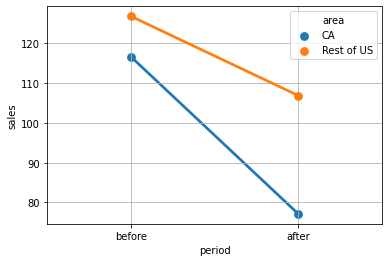

In [17]:
sns.pointplot(
    data=cigar_summarized,
    x='period',
    y='sales',
    hue='area',
    order=['before', 'after']
)

plt.grid()

In [18]:
cigar['post'] = cigar['year'].map(lambda x: 1 if x > 87 else 0)
cigar['ca'] = cigar['state'].map(lambda x: 1 if x == 5 else 0)

In [19]:
cigar_did_sum = cigar.groupby(['post', 'year', 'ca']).apply(lambda x: sum(x['sales']*x['pop16'])/sum(x['pop16'])).reset_index()
cigar_did_sum.columns = ['post', 'year', 'ca', 'sales']
cigar_did_sum['ca_post'] = cigar_did_sum['ca'] * cigar_did_sum['post']
cigar_did_sum.head()

,post,year,ca,sales,ca_post
0,0,70,0,115.033284,0
1,0,70,1,123.000000,0
2,0,71,0,118.117568,0
3,0,71,1,121.000000,0
4,0,72,0,120.857179,0


In [20]:
cigar_did_sum_reg = smf.ols(
    data=cigar_did_sum,
    formula='sales ~ ca + post + ca_post + year'
).fit()

cigar_did_sum_reg_result = pd.DataFrame(
    cigar_did_sum_reg.summary().tables[1].data[1:], 
    columns=cigar_did_sum_reg.summary().tables[1].data[0]
)

cigar_did_sum_reg_result = cigar_did_sum_reg_result.set_index('')

cigar_did_sum_reg_result.loc[['Intercept', 'ca', 'post', 'ca_post']]

,coef,std err,t,P>|t|,[0.025,0.975]
,,,,,,
Intercept,188.5366,19.055,9.895,0.000,150.055,227.018
ca,-9.0898,2.533,-3.588,0.001,-14.206,-3.974
post,-10.7662,4.742,-2.271,0.028,-20.342,-1.190
ca_post,-20.5435,5.433,-3.781,0.000,-31.516,-9.571


In [21]:
cigar_did_sum['log_sales'] = np.log(cigar_did_sum['sales'])

cigar_did_sum_logreg = smf.ols(
    data=cigar_did_sum,
    formula='log_sales ~ ca + post + ca_post + year'
).fit()

cigar_did_sum_logreg_result = pd.DataFrame(
    cigar_did_sum_logreg.summary().tables[1].data[1:], 
    columns=cigar_did_sum_logreg.summary().tables[1].data[0]
)

cigar_did_sum_logreg_result = cigar_did_sum_logreg_result.set_index('')

cigar_did_sum_logreg_result.loc[['Intercept', 'ca', 'post', 'ca_post']]

,coef,std err,t,P>|t|,[0.025,0.975]
,,,,,,
Intercept,5.4124,0.176,30.775,0.000,5.057,5.768
ca,-0.0767,0.023,-3.281,0.002,-0.124,-0.029
post,-0.0856,0.044,-1.957,0.057,-0.174,0.003
ca_post,-0.2530,0.050,-5.046,0.000,-0.354,-0.152


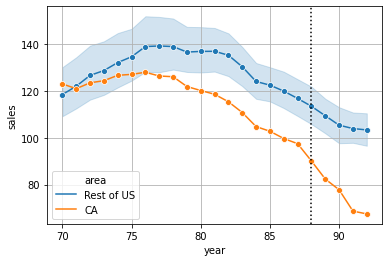

In [22]:
sns.lineplot(
    data=cigar,
    x='year',
    y='sales',
    hue='area',
    marker='o'
)

plt.grid()
plt.axvline([88], color='black', ls=':')

### 4.3.3 CausalImpactの実装

In [23]:
Y = pd.DataFrame(cigar.loc[cigar['state'] == 5].set_index('year')['sales'])
Y.columns = ['y']

X = cigar.loc[cigar['state'] != 5].pivot_table(columns=['state'], index=['year'], values=['sales'])
X.columns = ['X_'+str(i) for i in X.columns.levels[1]]
ci_data = pd.concat([Y, X], axis=1)

pre_period = [70, 87]
post_period = [88, 92]

ci_data.head()

,y,X_1,X_4,X_7,X_8,X_11,X_13,X_14,X_15,X_16,...,X_41,X_42,X_43,X_44,X_45,X_46,X_47,X_49,X_50,X_51
year,,,,,,,,,,,,,,,,,,,,,
70,123.0,89.8,100.3,120.0,155.0,109.9,102.4,124.8,134.6,108.5,...,103.6,92.7,99.8,106.4,65.5,122.6,124.3,114.5,106.4,132.2
71,121.0,95.4,104.1,117.6,161.1,115.7,108.5,125.6,139.3,108.4,...,115.0,96.7,106.3,108.9,67.7,124.4,128.4,111.5,105.4,131.7
72,123.5,101.1,103.9,110.8,156.3,117.0,126.1,126.6,149.2,109.4,...,118.7,103.0,111.5,108.6,71.3,138.0,137.0,117.5,108.8,140.0
73,124.4,102.9,108.0,109.3,154.7,119.8,121.8,124.4,156.0,110.6,...,125.5,103.5,109.7,110.4,72.7,146.8,143.1,116.6,109.5,141.2
74,126.7,108.2,109.7,112.4,151.3,123.7,125.6,131.9,159.6,116.1,...,129.7,108.4,114.8,114.7,75.6,151.8,149.6,119.9,111.8,145.8


/Users/shinya-yaginuma/.local/share/virtualenvs/cibook-study-D1CYHMng/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/shinya-yaginuma/.local/share/virtualenvs/cibook-study-D1CYHMng/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/shinya-yaginuma/.local/share/virtualenvs/cibook-study-D1CYHMng/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/shinya-yaginuma/.local/share/virtualenvs/cibook-study-D1CYHMng/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning: An unsupported index was provid

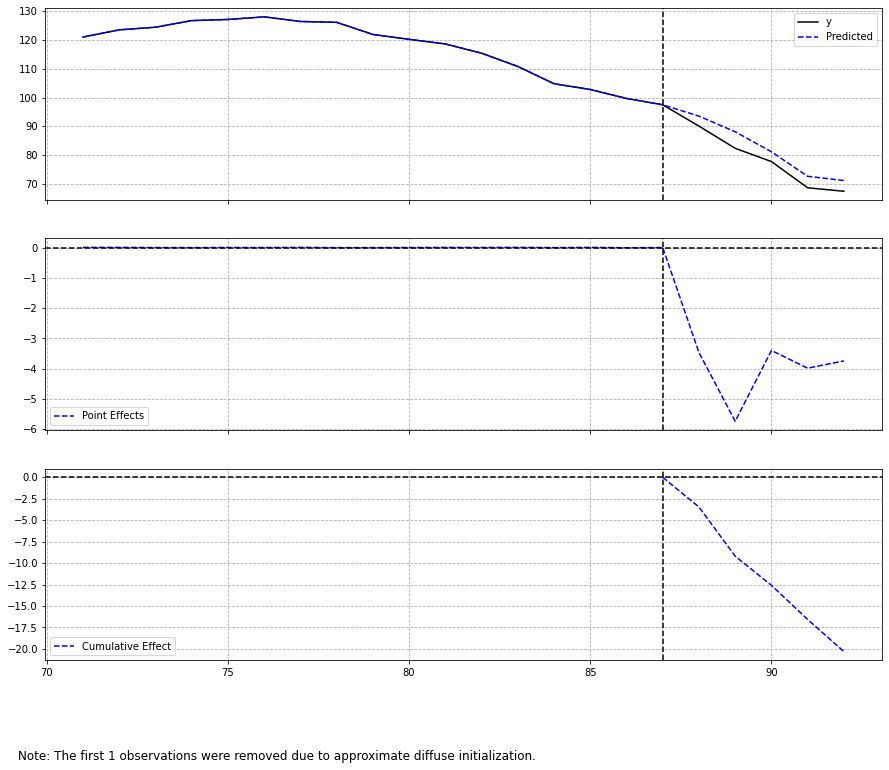

In [24]:
ci = CausalImpact(ci_data, pre_period, post_period, prior_level_sd=None)
ci.plot()

In [25]:
print(ci.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    77.3               386.5
Prediction (s.d.)         81.36 (0.0)        406.82 (0.01)
95% CI                    [81.36, 81.37]     [406.8, 406.83]

Absolute effect (s.d.)    -4.06 (0.0)        -20.32 (0.01)
95% CI                    [-4.07, -4.06]     [-20.33, -20.3]

Relative effect (s.d.)    -4.99% (0.0%)      -4.99% (0.0%)
95% CI                    [-5.0%, -4.99%]    [-5.0%, -4.99%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))
